HW4 Pytorch: Classification, Autoencoders, Word Embedding, Image Features, LSTM

PROBLEM 1: Setup a tensor library [Optional, no credit]

A) Setup your favorite tensor-based library for deep learning, such as PyTorch or TensorFlow, and familiarize yourself with its basic usage. If using PyTorch, you can test if it is installed properly with (in Python):

B) Train a simple feed-forward neural network on the MNIST dataset with 80/20 train and test splits and report results



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.01
momentum = 0.9
epochs = 5  # You can increase for better accuracy

# MNIST dataset (download + transform)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full dataset
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Net Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2)            # Pool after conv1
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)            # Pool after conv2
      x = self.dropout(x)
      x = torch.flatten(x, 1)           # Flatten
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)


model = CNN().to(device)

# Optimizer and Loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
criterion = nn.NLLLoss()

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

accuracy = 100. * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1, Loss: 219.8138
Epoch 2, Loss: 52.8084
Epoch 3, Loss: 36.8860
Epoch 4, Loss: 29.0962
Epoch 5, Loss: 22.8169
Test Accuracy: 98.77%


PROBLEM 2 : NNet supervised classification with tuned word vectors

Train a neural network on a sizeable subset of 20NG (say, at least 5 categories)


Setup and preprocessing:

In [37]:
!pip install --upgrade gensim

In [38]:
# STEP 2: Load and preprocess dataset
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
from collections import Counter
import re

# Load a subset of categories
categories = ['comp.graphics', 'sci.space', 'rec.sport.baseball', 'talk.politics.misc', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
texts, labels = newsgroups.data, newsgroups.target

# Tokenize
tokenized_texts = [simple_preprocess(text) for text in texts]

# Filter short docs (important!)
filtered = [(doc, label) for doc, label in zip(tokenized_texts, labels) if len(doc) >= 3]
tokenized_texts, labels = zip(*filtered)

Load GloVe and create Vocabulary

In [39]:
# STEP 3: Build vocabulary (after filtering)
word_counts = Counter(word for doc in tokenized_texts for word in doc)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [41]:
# STEP 4: Load GloVe embeddings
import numpy as np

embedding_dim = 100
glove_path = 'glove.6B.100d.txt'  # Make sure to upload this file in Colab
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]

Converting Docs to Indices

In [42]:
# STEP 5: Convert tokens to indices, pad sequences
import torch
from torch.nn.utils.rnn import pad_sequence

def doc2ind(doc):
    return [vocab.get(token, vocab['<UNK>']) for token in doc]

indexed_docs = [doc2ind(doc) for doc in tokenized_texts]
padded_docs = pad_sequence([torch.tensor(doc) for doc in indexed_docs], batch_first=True, padding_value=vocab['<PAD>'])
labels_tensor = torch.tensor(labels)

Create Dataset and Dataloader

In [43]:
# STEP 6: Dataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(padded_docs, labels_tensor)
train_len = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

Define our Neural Network

In [44]:
# STEP 7: Define model
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(embedding_matrix, dtype=torch.float32),
    freeze=False,
    padding_idx=vocab['<PAD>']
)

class TextClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = embedding_layer
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = torch.max(x, dim=1)  # Max pooling
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

model = TextClassifier(embedding_layer, hidden_dim=128, num_classes=len(categories)).to(device)

Train the model

In [45]:
# STEP 8: Training loop with evaluation
from sklearn.metrics import classification_report

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def evaluate(model, val_dl):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in val_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=categories))
    acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return 100 * acc

for epoch in range(15):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    val_acc = evaluate(model, val_dl)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.2f}%")

                        precision    recall  f1-score   support

         comp.graphics       0.50      0.01      0.02       111
             sci.space       0.29      0.84      0.43       134
    rec.sport.baseball       0.47      0.15      0.23       111
    talk.politics.misc       0.34      0.39      0.36       122
soc.religion.christian       0.45      0.06      0.10        90

              accuracy                           0.32       568
             macro avg       0.41      0.29      0.23       568
          weighted avg       0.40      0.32      0.24       568

Epoch 1, Loss: 58.1142, Val Acc: 32.04%
                        precision    recall  f1-score   support

         comp.graphics       0.32      0.17      0.22       111
             sci.space       0.78      0.24      0.37       134
    rec.sport.baseball       0.49      0.51      0.50       111
    talk.politics.misc       0.35      0.85      0.50       122
soc.religion.christian       0.46      0.28      0.35       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

         comp.graphics       0.52      0.10      0.17       111
             sci.space       0.70      0.66      0.68       134
    rec.sport.baseball       0.35      0.94      0.51       111
    talk.politics.misc       0.67      0.67      0.67       122
soc.religion.christian       0.00      0.00      0.00        90

              accuracy                           0.50       568
             macro avg       0.45      0.47      0.41       568
          weighted avg       0.48      0.50      0.44       568

Epoch 4, Loss: 52.5151, Val Acc: 50.35%
                        precision    recall  f1-score   support

         comp.graphics       0.49      0.30      0.37       111
             sci.space       0.81      0.65      0.72       134
    rec.sport.baseball       0.54      0.90      0.68       111
    talk.politics.misc       0.87      0.51      0.64       122
soc.religion.christian       0.50      0.76      0.60       

In [47]:
# STEP 10: Evaluate on official 20NG test set
from sklearn.datasets import fetch_20newsgroups

# Load the official test set with same categories
test_newsgroups = fetch_20newsgroups(subset='test', categories=categories)
test_texts, test_labels = test_newsgroups.data, test_newsgroups.target

# Tokenize and filter short docs
test_tokenized = [simple_preprocess(text) for text in test_texts]
filtered_test = [(doc, label) for doc, label in zip(test_tokenized, test_labels) if len(doc) >= 3]
test_tokenized, test_labels = zip(*filtered_test)

# Convert test docs to indices
test_indexed = [doc2ind(doc) for doc in test_tokenized]
test_padded = pad_sequence([torch.tensor(doc) for doc in test_indexed], batch_first=True, padding_value=vocab['<PAD>'])
test_labels_tensor = torch.tensor(test_labels)

# Create test DataLoader
from torch.utils.data import TensorDataset, DataLoader
test_ds = TensorDataset(test_padded, test_labels_tensor)
test_dl = DataLoader(test_ds, batch_size=64)

# Evaluate using the same function
print("Evaluating on official test set:")
test_acc = evaluate(model, test_dl)
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating on official test set:
                        precision    recall  f1-score   support

         comp.graphics       0.73      0.92      0.81       389
             sci.space       0.93      0.92      0.93       397
    rec.sport.baseball       0.97      0.72      0.82       394
    talk.politics.misc       0.90      0.95      0.92       398
soc.religion.christian       0.85      0.82      0.83       310

              accuracy                           0.87      1888
             macro avg       0.88      0.86      0.86      1888
          weighted avg       0.88      0.87      0.87      1888

Test Accuracy: 86.55%


Visualization of embeddings using TSNE

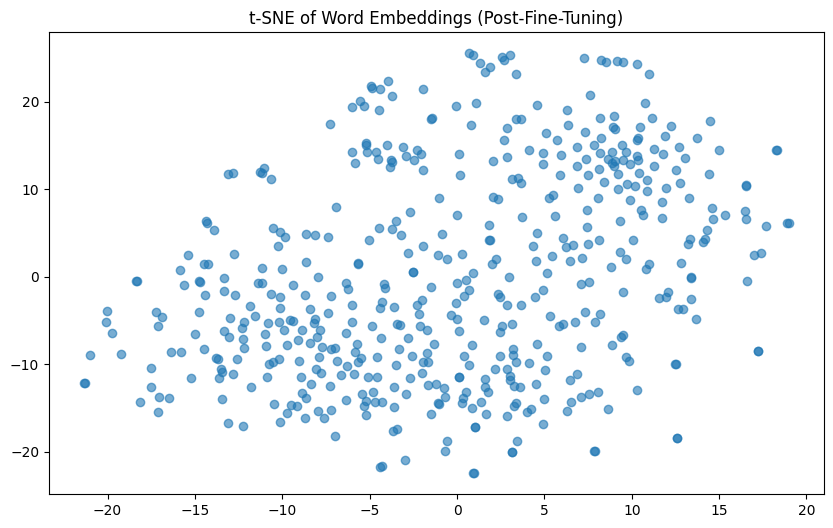

In [48]:
# STEP 9: Visualize GloVe embeddings after fine-tuning (optional)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Unfreeze embedding layer for further fine-tuning (if you want to train more)
model.embedding.weight.requires_grad = True

# Visualize word embeddings (sample 500)
sample_idx = [vocab[word] for word in list(vocab.keys())[:500]]
sample_vectors = model.embedding.weight.data[sample_idx].cpu().numpy()

tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(sample_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
plt.title("t-SNE of Word Embeddings (Post-Fine-Tuning)")
plt.show()

PROBLEM 3 [Optional, no credit]: Autoencoders

You can pick your own text to fine tune word vectors, if its reasonable in size and very domain-specific (compared to general English). Suggestions:
- Alice in Wonderland
- Sonnets
- specific categories (labels) from 20NG or Reurters datasets
- use your favorite specific text (like a book, or project)


PROBLEM 4 [Optional, no credit]: Autoencoders

For each one of the datasets MNIST, 20NG (required) and SPAMBASE, FASHION (optional) run as an autoencoder with pytorch with a desired hidden layer size (try K=5,10, 20, 100, 200)- what is the smaleest K that works?).

Load the data with dataloader https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Construct an Autoencoder with the following architecture :

Two linear layers with in features matching the dimensions of input and out

features matching the size of K

Two linear layers with in features matching K and size of out features matching the size of input dimensions.

Define a forward pass with relu

Code a train loop with number of epochs as 10.

Define loss and Optimizer (Adam)

Train the model

use gpu if available

use mean-squared error loss

create a model from Autoencoder class load it to the specified device, either gpu or cpu

Verify the obtained re-encoding of data (the new feature representation) in several ways:

repeat a classification train/test task , or a clustering taks
examine the new pairwise distances dist(i,j) agains the old distances obtained with original features (sample 100 pairs of related words)
examine the top 20 neighbors (by new distance) set overlap with old neighbors, per datapoint
for images, rebuild the image form output layer and draw to look at it


PROBLEM 5 [Optional, no credit]: Image Feature Extraction

Run a Convolutional Neural Network in pytorch to extract image features. In practice the network usually does both the feature extraction and the supervised task (classification) in one pipeline.


PROBLEM 6 [Optional, no credit]: LSTM for text

Run a Recurrent Neural Network/LSTM in Pytorch to model word dependecies/order in text. Can be use for translation, next-word prediction, event detection etc.
